Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cpu
Total: 2501 | Train: 2000 | Val: 250 | Test: 251


Extracting Features: 100%|██████████| 2501/2501 [06:07<00:00,  6.81it/s]



Random Forest Dataset Sizes:
Train: 2000 | Val: 250 | Test: 251

Training Random Forest Classifier...

Evaluating on Test Set...

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99       156
      Stroke       1.00      0.97      0.98        95

    accuracy                           0.99       251
   macro avg       0.99      0.98      0.99       251
weighted avg       0.99      0.99      0.99       251



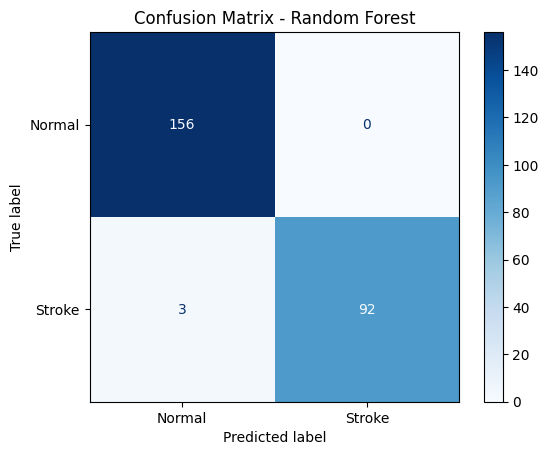

In [2]:
# STEP 1: SETUP
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from glob import glob
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# STEP 2: PATHS AND SETTINGS
dataset_path = "/content/drive/MyDrive/Data"
image_size = (224, 224)
num_classes = 2

# STEP 3: LOAD IMAGE PATHS
normal_paths = glob(os.path.join(dataset_path, "Normal", "*.jpg"))
stroke_paths = glob(os.path.join(dataset_path, "Stroke", "*.jpg"))
image_paths = normal_paths + stroke_paths
random.shuffle(image_paths)

# STEP 4: SPLIT DATA
train_ratio = 0.8
train_size = int(train_ratio * len(image_paths))
train_paths = image_paths[:train_size]
test_paths = image_paths[train_size:]
val_paths, test_paths = train_test_split(test_paths, test_size=0.5)

print(f"Total: {len(image_paths)} | Train: {len(train_paths)} | Val: {len(val_paths)} | Test: {len(test_paths)}")

# STEP 5: TRANSFORMS
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# STEP 6: DATASET CLASS
class StrokeDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
        self.label_map = {'Normal': 0, 'Stroke': 1}
        self.labels = [self.label_map[self.get_label(p)] for p in paths]

    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

    def __getitem__(self, index):
        img = Image.open(self.paths[index]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.paths)

# STEP 7: LOADERS
train_dataset = StrokeDataset(train_paths, transform=train_transform)
val_dataset = StrokeDataset(val_paths, transform=test_transform)
test_dataset = StrokeDataset(test_paths, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# STEP 8: RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

# ========================== Extract Flattened Features ==========================
def extract_flattened_features(image_paths, transform):
    features = []
    labels = []
    for path in tqdm(image_paths, desc="Extracting Features"):
        img = Image.open(path).convert("RGB")
        img = transform(img)
        img = img.view(-1).numpy()  # Flatten to 1D
        features.append(img)
        label = 0 if "Normal" in path else 1
        labels.append(label)
    return np.array(features), np.array(labels)

# Use test_transform (resize + normalize) for simplicity
flatten_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ========================== Extract Features and Split ==========================
X, y = extract_flattened_features(image_paths, flatten_transform)

# Using the same train-test split ratio as above (80-10-10 split)
X_train_rf, X_temp, y_train_rf, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val_rf, X_test_rf, y_val_rf, y_test_rf = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"\nRandom Forest Dataset Sizes:")
print(f"Train: {len(X_train_rf)} | Val: {len(X_val_rf)} | Test: {len(X_test_rf)}")

# ========================== Train Random Forest ==========================
print("\nTraining Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# ========================== Evaluate Random Forest ==========================
print("\nEvaluating on Test Set...")
y_pred_rf = rf_model.predict(X_test_rf)

print("\nClassification Report:")
print(classification_report(y_test_rf, y_pred_rf, target_names=["Normal", "Stroke"]))

cm = confusion_matrix(y_test_rf, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Stroke"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()



# Random Forest Code with Cross-Validation

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cpu
Total: 2501 | Train: 2000 | Val: 250 | Test: 251


Extracting Features: 100%|██████████| 2501/2501 [00:28<00:00, 87.13it/s] 



Performing 5-Fold Cross-Validation...

Cross-Validation Accuracy Scores: [0.97804391 0.98       0.984      0.986      0.97      ]
Mean Accuracy: 97.96%
Standard Deviation: 0.56%

Random Forest Dataset Sizes:
Train: 2000 | Val: 250 | Test: 251

Training Random Forest Classifier on Train Set...

Evaluating on Test Set...

Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      1.00      0.97       156
      Stroke       1.00      0.91      0.95        95

    accuracy                           0.96       251
   macro avg       0.97      0.95      0.96       251
weighted avg       0.97      0.96      0.96       251



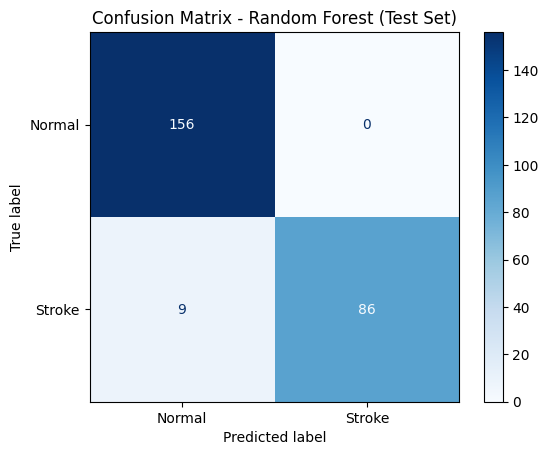

In [3]:
# STEP 1: SETUP
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from glob import glob
import os
import random
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# STEP 2: PATHS AND SETTINGS
dataset_path = "/content/drive/MyDrive/Data"
image_size = (224, 224)
num_classes = 2

# STEP 3: LOAD IMAGE PATHS
normal_paths = glob(os.path.join(dataset_path, "Normal", "*.jpg"))
stroke_paths = glob(os.path.join(dataset_path, "Stroke", "*.jpg"))
image_paths = normal_paths + stroke_paths
random.shuffle(image_paths)

# STEP 4: SPLIT DATA
train_ratio = 0.8
train_size = int(train_ratio * len(image_paths))
train_paths = image_paths[:train_size]
test_paths = image_paths[train_size:]
val_paths, test_paths = train_test_split(test_paths, test_size=0.5)

print(f"Total: {len(image_paths)} | Train: {len(train_paths)} | Val: {len(val_paths)} | Test: {len(test_paths)}")

# STEP 5: TRANSFORMS
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# STEP 6: DATASET CLASS
class StrokeDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
        self.label_map = {'Normal': 0, 'Stroke': 1}
        self.labels = [self.label_map[self.get_label(p)] for p in paths]

    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

    def __getitem__(self, index):
        img = Image.open(self.paths[index]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.paths)

# STEP 7: LOADERS
train_dataset = StrokeDataset(train_paths, transform=train_transform)
val_dataset = StrokeDataset(val_paths, transform=test_transform)
test_dataset = StrokeDataset(test_paths, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# STEP 8: RANDOM FOREST
# Extract Flattened Features
def extract_flattened_features(image_paths, transform):
    features = []
    labels = []
    for path in tqdm(image_paths, desc="Extracting Features"):
        img = Image.open(path).convert("RGB")
        img = transform(img)
        img = img.view(-1).numpy()  # Flatten to 1D
        features.append(img)
        label = 0 if "Normal" in path else 1
        labels.append(label)
    return np.array(features), np.array(labels)

# Define transform for Random Forest input
flatten_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Extract features
X, y = extract_flattened_features(image_paths, flatten_transform)

# STEP 9: CROSS-VALIDATION
print("\nPerforming 5-Fold Cross-Validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_model_cv = RandomForestClassifier(n_estimators=100, random_state=42)

cv_scores = cross_val_score(rf_model_cv, X, y, cv=skf, scoring='accuracy')

print("\nCross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy: {:.2f}%".format(np.mean(cv_scores) * 100))
print("Standard Deviation: {:.2f}%".format(np.std(cv_scores) * 100))

# STEP 10: FINAL TRAIN/TEST SPLIT AND TRAINING
X_train_rf, X_temp, y_train_rf, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val_rf, X_test_rf, y_val_rf, y_test_rf = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"\nRandom Forest Dataset Sizes:")
print(f"Train: {len(X_train_rf)} | Val: {len(X_val_rf)} | Test: {len(X_test_rf)}")

print("\nTraining Random Forest Classifier on Train Set...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# STEP 11: EVALUATION
print("\nEvaluating on Test Set...")
y_pred_rf = rf_model.predict(X_test_rf)

print("\nClassification Report:")
print(classification_report(y_test_rf, y_pred_rf, target_names=["Normal", "Stroke"]))

cm = confusion_matrix(y_test_rf, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Stroke"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest (Test Set)")
plt.show()
